# Copyright & Acknowledgements

# Time Series Forecasting Project

# Setup

## Load Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

import IPython
import IPython.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.data.Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


from prophet import Prophet

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set Plotting Styles
#plt.style.use('ggplot')

## Load Dataset

In [4]:
# Define location of datasets
path = "C:\\Users\\coope\\Data_Science\\Datasets\\Energy"

# Load in data
energy = pd.read_csv(path + '\hrl_load_metered.csv', index_col=[0], parse_dates=[0])
energy_t1 = pd.read_csv(path + '\hrl_load_metered - test1.csv', index_col=[0], parse_dates=[0])
energy_t2 = pd.read_csv(path + '\hrl_load_metered - test2.csv', index_col=[0], parse_dates=[0])
energy_t3 = pd.read_csv(path + '\hrl_load_metered - test3.csv', index_col=[1], parse_dates=[1])
energy_t4 = pd.read_csv(path + '\hrl_load_metered - test4.csv', index_col=[0], parse_dates=[0])
energy_t5 = pd.read_csv(path + '\hrl_load_metered - test5.csv', index_col=[0], parse_dates=[0])

energy_t3 = energy_t3.drop(['datetime_beginning_utc'], axis = 1)

# Combine dataframes for cleaning dataset
total_energy = pd.concat([energy, energy_t1, energy_t2, energy_t3, energy_t4, energy_t5])

total_energy.head(10)

,nerc_region,mkt_region,zone,load_area,mw,is_verified
datetime_beginning_ept,,,,,,
2016-01-01 00:00:00,RFC,WEST,AEP,AEPAPT,4064.992,True
2016-01-01 01:00:00,RFC,WEST,AEP,AEPAPT,4023.104,True
2016-01-01 02:00:00,RFC,WEST,AEP,AEPAPT,4009.598,True
2016-01-01 03:00:00,RFC,WEST,AEP,AEPAPT,4004.521,True
2016-01-01 04:00:00,RFC,WEST,AEP,AEPAPT,4080.944,True
2016-01-01 05:00:00,RFC,WEST,AEP,AEPAPT,4177.135,True
2016-01-01 06:00:00,RFC,WEST,AEP,AEPAPT,4316.690,True
2016-01-01 07:00:00,RFC,WEST,AEP,AEPAPT,4471.222,True
2016-01-01 08:00:00,RFC,WEST,AEP,AEPAPT,4574.792,True


# Preprocessing & Cleanup

In [3]:
# Drop unnessesary columns
aep_df = total_energy.drop(columns = ["nerc_region", "zone", "mkt_region", "load_area", "is_verified"])

# Rename Index
aep_df.index.names = ["Datetime"]

# Sort Data
aep_df.sort_index(inplace = True)

# Identify Duplicate Indices
duplicate_index = aep_df[aep_df.index.duplicated()]
print(aep_df.loc[duplicate_index.index.values, :])

# Replace Duplicates with Mean Value
aep_df = aep_df.groupby('Datetime').agg(np.mean)

#Set Datetime Index Frequency
aep_df = aep_df.asfreq('H')

# Determine # of Missing Values
print('# of Missing df_MW Values:{}'.format(len(aep_df[aep_df['mw'].isna()])))

# Impute Missing Values
aep_df['mw'] = aep_df['mw'].interpolate(limit_area = 'inside', limit = None)

                           mw
Datetime                     
2016-11-06 01:00:00  3608.340
2016-11-06 01:00:00  3608.197
2017-11-05 01:00:00  3296.872
2017-11-05 01:00:00  3251.448
2018-11-04 01:00:00  4073.050
2018-11-04 01:00:00  4089.423
2019-11-03 01:00:00  4067.316
2019-11-03 01:00:00  4053.021
2020-11-01 01:00:00  3704.506
2020-11-01 01:00:00  3656.434
2021-11-07 01:00:00  4042.513
2021-11-07 01:00:00  4081.986
2022-11-06 01:00:00  3091.819
2022-11-06 01:00:00  3028.478
# of Missing df_MW Values:8


## EDA

In [4]:
aep_df.head(10)

,mw
Datetime,
2016-01-01 00:00:00,4064.992
2016-01-01 01:00:00,4023.104
2016-01-01 02:00:00,4009.598
2016-01-01 03:00:00,4004.521
2016-01-01 04:00:00,4080.944
2016-01-01 05:00:00,4177.135
2016-01-01 06:00:00,4316.690
2016-01-01 07:00:00,4471.222
2016-01-01 08:00:00,4574.792


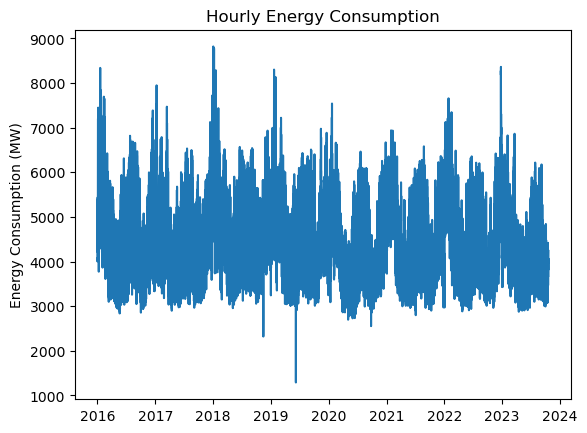

In [5]:
## Visualize Energy Consumption
plt.plot(aep_df.index, aep_df['mw'])
plt.title('Hourly Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [8]:
aep_df.describe()

,mw
count,68352.000000
mean,4444.320528
std,836.787568
min,1289.923000
25%,3827.639500
50%,4308.691000
75%,4987.340750
max,8820.496000


## Feature Engineering

## Time

In [13]:
date_time = pd.to_datetime(aep_df.index, format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

aep_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
aep_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
aep_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
aep_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

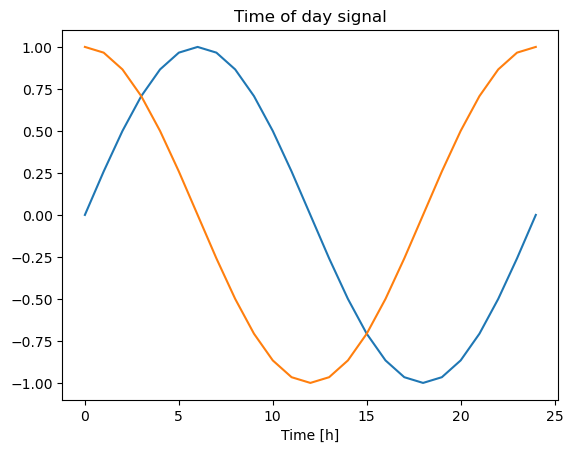

In [16]:
plt.plot(np.array(aep_df['Day sin'])[:25])
plt.plot(np.array(aep_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

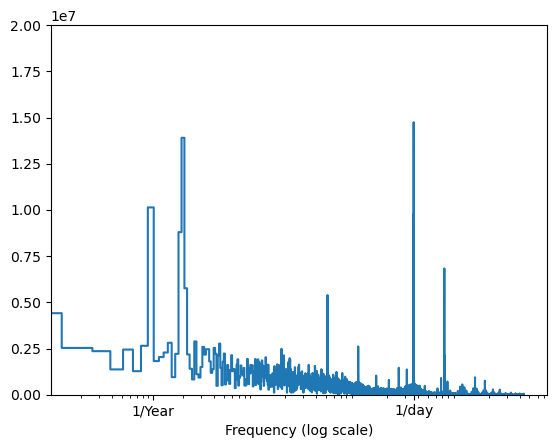

In [23]:
fft = tf.signal.rfft(aep_df['mw'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(aep_df['mw'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Forecasting 24 Hours Ahead

## Time Series Modeling with statsmodels

### Train/Test Split

In [ ]:
# Create Train and Test Datasets
train = aep_df.loc[(aep_df.index >= datetime(2016, 1, 1)) & (aep_df.index < datetime(2023, 10, 12)), 'mw']
test = aep_df.loc[(aep_df.index >= datetime(2023, 10, 12)), 'mw']

### Exponential Smooting Models

In [ ]:
## ESM Models
# Create and fit Holt-Winters ESM
HW_Model = ExponentialSmoothing(train.values, seasonal_periods = 24, trend = None, seasonal = 'mul')
HW_model_fit = HW_Model.fit()
print(HW_model_fit.mle_retvals)

# Generate Forecast
HW_pred = HW_model_fit.forecast(steps = len(test))
HW_pred_series = pd.Series(HW_pred, index = test.index)

# Evaluate Model
HW_mae = mae(test, HW_pred_series)
HW_mape = mape(test, HW_pred_series)

### ARIMA

In [ ]:
## Seasonal ARIMA
model1 = pm.auto_arima(train, start_p = 1, start_q = 5, start_P = 2, start_Q = 0, d = None, D = 1, seasonal = True, m = 24, Trace = True)
model1.summary()

### Prophet

In [ ]:
# Prophet Model

## Process Data to Use Prophet
train_df = pd.DataFrame(train).reset_index(drop = False)
train_df.columns = ['ds', 'y']


# Create model, assuming multiplicative seasonality. 
prophet_model = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality = False)
###prophet_model = Prophet(seasonality_mode = 'additive')

# Add U.S. holiday effects
prophet_model.add_country_holidays(country_name = 'US')

# Add Custom Seasonality
prophet_model.add_seasonality(name = "Yearly", period = 365.25, fourier_order = 2)

# Train model
prophet_model.fit(train_df)

# Generate forecasts
future = prophet_model.make_future_dataframe(periods = len(test), freq = 'H')
forecast = prophet_model.predict(future)

prophet_preds = forecast['yhat'][-168:].values

# Evaluate performance
mape_score = mape(test.values, prophet_preds)
print(mape_score)

mae_score = mae(test.values, prophet_preds)
print(mae_score)

error_prophet = test.values - forecast['yhat'].tail(168).values
MAPE = np.mean(abs(error_prophet) / test)*100
print(MAPE)


# Graph Model
fig, axes = plt.subplots(figsize = (16, 16))

prophet_preds_series = pd.Series(prophet_preds, index = test.index)

axes.plot(test, label = 'Observed Values')
axes.plot(prophet_preds_series, color = 'blue', label = 'Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('Prophet Forecasts')



fig = prophet_model.plot(forecast)
plt.show()




fig = prophet_model.plot_components(forecast)

### Autoregressive Neural Network

In [ ]:
# Create Train and Test Datasets
train = aep_df.head(len(aep_df) - 168)
test = aep_df.tail(168)


# Add in lagged terms for train data
train['diff'] = train['mw'] - train['mw'].shift(24)
train['L1'] = train['diff'].shift()
train['L2'] = train['diff'].shift(2)
train['L24'] = train['diff'].shift(24)
train['L48'] = train['diff'].shift(48)

# Graph of differenced data
plt.cla()
plt.plot(train['diff'])
plt.xlabel("Date")
plt.ylabel("Energy Use (MW)")
plt.title("Seasonal Difference in Energy Use")
plt.show()


# Remove lags that are NA
train_clean = train.tail(len(train) - 72)


# Create Dataframe with only the last 48 hours
last_48 = train_clean.tail(48)



# Create training X and Y splits
X = train_clean.drop(['mw', 'diff'], axis = 1)
y = train_clean['diff']


# Create Neural Network using train dataset
NN_Energy = MLPRegressor(hidden_layer_sizes = (3,), random_state = 12345, max_iter = 100000).fit(X, y)


# Create date range for index
num_of_preds = 168
prediction_date_range = pd.date_range(start = train.index[-1], freq = 'H', periods = num_of_preds + 1)[1:169]


# Loop through 168 predictions
for i in range(0, 168):
    
    # Create lag variables
    l1 = last_48.iloc[-1, 1]
    l2 = last_48.iloc[-2, 1]
    l24 = last_48.iloc[-24, 1]
    l48 = last_48.iloc[-48, 1]
    
    X_test = pd.DataFrame(np.array([[l1, l2, l24, l48]]), columns = ['L1', 'L2', 'L24', 'L48'], index = [prediction_date_range[i]])
    
    # Predict next hour's energy load (differences in lags) and append
    nn_pred = NN_Energy.predict(X_test)
    X_test['diff'] = nn_pred
    
    # Calculate the energy load from the predicted difference and the energy load from 24 hours ago
    X_test['mw'] = nn_pred + last_48['mw'][-24]
    
    last_48 = pd.concat([last_48, X_test])



pred = last_48.tail(168)


# MAPE for t1
error = test['mw'] - pred['mw']
MAPE = np.mean(abs(error)/test['mw'])*100
print(MAPE)

# MAE for t1
MAE = np.mean(abs(error))
print(MAE)

## Time Series Modeling with TensorFlow (Single Shot)

### Simple Example of LSTM

In [ ]:
# Long Short-Term Memory (LSTM) Neural Networks

np.random.seed(12345)



# Apply MinMaxScaler to training and test data. Fit to training data, use to transform train + test

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_train_values = scaler.fit_transform(train.values.reshape(-1, 1))
train_series_scaled = pd.Series(data = scaled_train_values.reshape(1, -1)[0], index = train.index)

# Create TimeseriesGenerator using training data and selected hyperparameters

n_input = 24
n_features = 1
sampling_rate = 1
stride = 1
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train_values, 
                                      scaled_train_values, 
                                      length = n_input,
                                      sampling_rate = sampling_rate,
                                      stride = stride,
                                      batch_size = batch_size)

# Build and fit model
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences = False, input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(train_generator, epochs = 80)





# Generate predictions

lstm_preds = []

batch = scaled_train_values[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    lstm_preds.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis = 1)
    
# Evaluate performance
    
lstm_preds = scaler.inverse_transform(lstm_preds)
lstm_preds = [item for sublist in lstm_preds for item in sublist]
    
test_score = mean_squared_error(test.values, lstm_preds)
print(test_score)




fig, axes = plt.subplots(figsize = (16,16))

LSTM_preds_series = pd.Series(lstm_preds, index = test.index)

axes.plot(test, label = 'Observed Values')
axes.plot(LSTM_preds_series, color = 'blue', label = 'Forecasted Values')
plt.xlabel('Date (MM-DD HH)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
axes.title.set_text('LSTM Forecasts')




lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

### Multi-step Models

#### Setup

##### Train/Validation/Test Split

In [25]:
df = aep_df

# Split Between Test, Train, and Validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]

num_features = df.shape[1]

In [26]:
test_df

,mw,Day sin,Day cos,Year sin,Year cos
Datetime,,,,,
2023-01-07 04:00:00,5019.778,0.866025,5.000000e-01,0.108408,0.994107
2023-01-07 05:00:00,5132.708,0.965926,2.588190e-01,0.109120,0.994029
2023-01-07 06:00:00,5236.727,1.000000,2.616574e-12,0.109833,0.993950
2023-01-07 07:00:00,5383.727,0.965926,-2.588190e-01,0.110545,0.993871
2023-01-07 08:00:00,5477.803,0.866025,-5.000000e-01,0.111258,0.993792
...,...,...,...,...,...
2023-10-18 19:00:00,4069.118,-0.965926,2.588190e-01,-0.957505,0.288416
2023-10-18 20:00:00,4066.731,-0.866025,5.000000e-01,-0.957298,0.289103
2023-10-18 21:00:00,3970.210,-0.707107,7.071068e-01,-0.957091,0.289789


##### Normalize Data

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

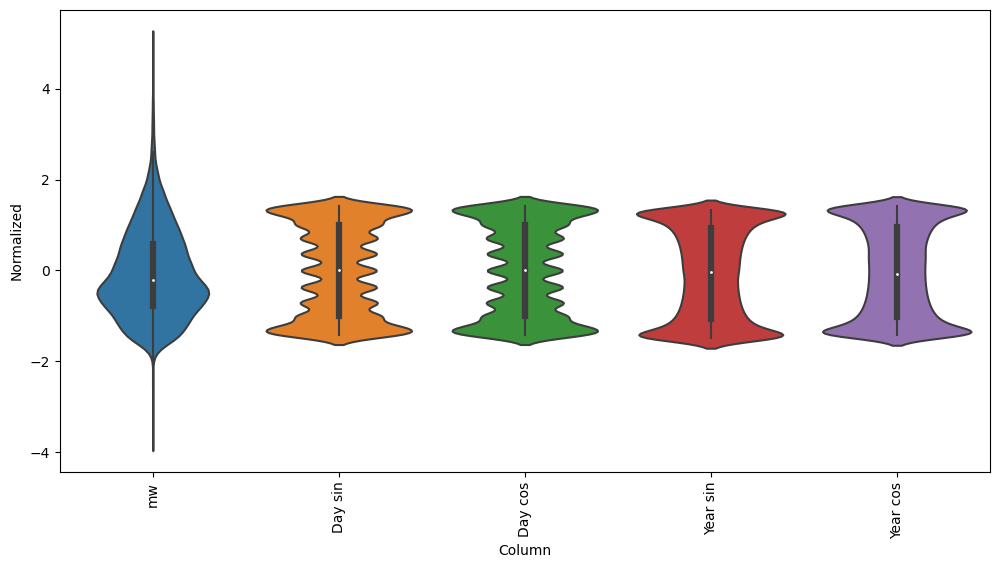

In [28]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#### Data Windowing Functions

In [29]:
## Indexes and Offsets
# Create WindowGenerator Function

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = train_df, val_df = val_df, test_df = test_df,
               label_columns = None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [30]:
## Split into window of inputs and labels

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
## Plot method of split window

def plot(self, model=None, plot_col='mw', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [32]:
# Method to convert to tf.data.Datasets

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
# Add properties to WindowGenerator Object

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Number of Predictions
OUT_STEPS = 24

multi_window = WindowGenerator(input_width = 24, # How many hours the model is given
                               label_width = OUT_STEPS,
                               shift = OUT_STEPS)

multi_window.plot()
multi_window

#### Baseline Model

# Forecasting 1 Week Ahead (168 Hours)

# Time Series Modeling (Single Step)

### Baseline Model

#### 1 hour ahead

In [34]:
single_step_window = WindowGenerator(
    input_width = 1, label_width = 1, shift = 1,
    label_columns = ['mw'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mw']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [36]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index = None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [37]:
baseline = Baseline(label_index = column_indices['mw'])

baseline.compile(loss = tf.keras.losses.MeanSquaredError(),
                 metrics = [tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose = 0)

428/428 [==============================] - 1s 1ms/step - loss: 0.0358 - mean_absolute_error: 0.1511


### Window Generation for 1 hour ahead forecast for 24 hours

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


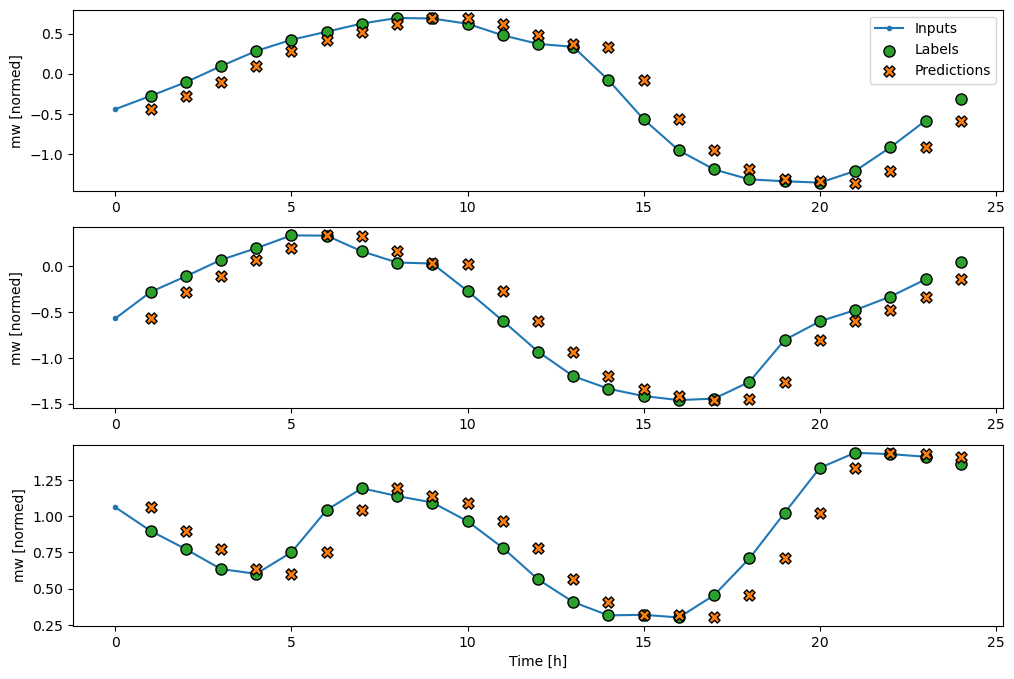

In [38]:
# Create window with 24 hours of inputs and labels

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['mw'])

wide_window

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


wide_window.plot(baseline)

### Function for training models

In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### Linear Model

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.2875 - mean_absolute_error: 0.3695 - val_loss: 0.0346 - val_mean_absolute_error: 0.1474
Epoch 2/20
1496/1496 [==============================] - 1s 783us/step - loss: 0.0310 - mean_absolute_error: 0.1370 - val_loss: 0.0275 - val_mean_absolute_error: 0.1280
Epoch 3/20
1496/1496 [==============================] - 1s 784us/step - loss: 0.0302 - mean_absolute_error: 0.1342 - val_loss: 0.0275 - val_mean_absolute_error: 0.1281
Epoch 4/20
428/428 [==============================] - 0s 602us/step - loss: 0.0275 - mean_absolute_error: 0.1284


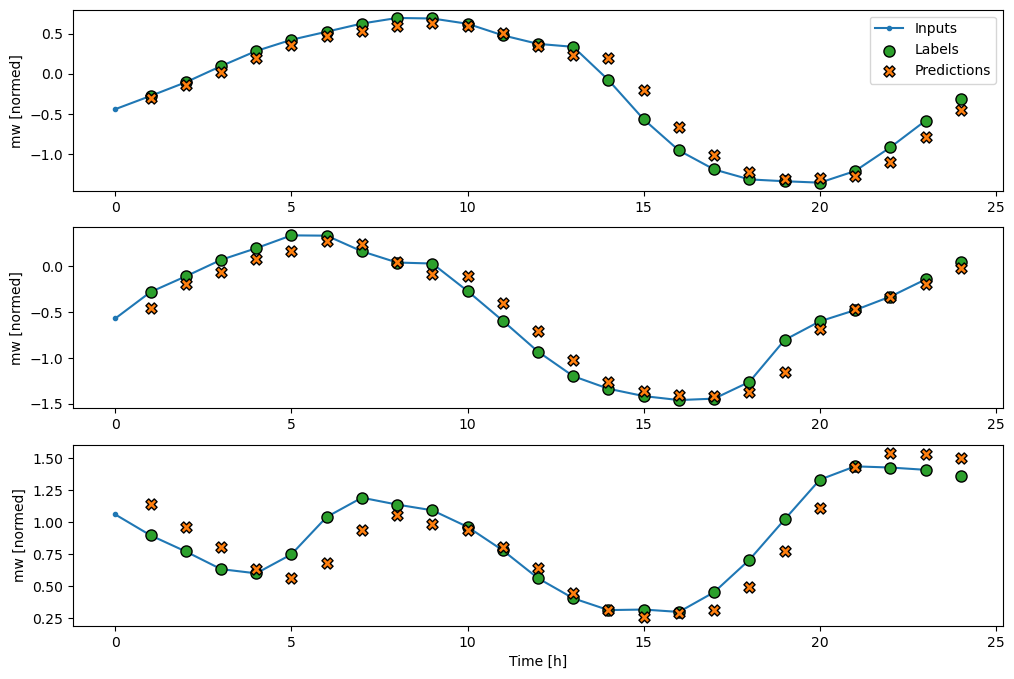

In [42]:
wide_window.plot(linear)

### Dense

In [43]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.0897 - val_loss: 0.0089 - val_mean_absolute_error: 0.0726
Epoch 2/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0084 - mean_absolute_error: 0.0676 - val_loss: 0.0065 - val_mean_absolute_error: 0.0614
Epoch 3/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0658 - val_loss: 0.0068 - val_mean_absolute_error: 0.0637
Epoch 4/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0077 - mean_absolute_error: 0.0643 - val_loss: 0.0064 - val_mean_absolute_error: 0.0603
Epoch 5/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0636 - val_loss: 0.0061 - val_mean_absolute_error: 0.0587
Epoch 6/20
1496/1496 [==============================] - 2s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0630 - val_loss: 0.0069 - val_mean_absolute_error: 0.0643
Epoc

### Multi-Step Dense

In [44]:
## Multi-step Dense

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['mw'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['mw']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

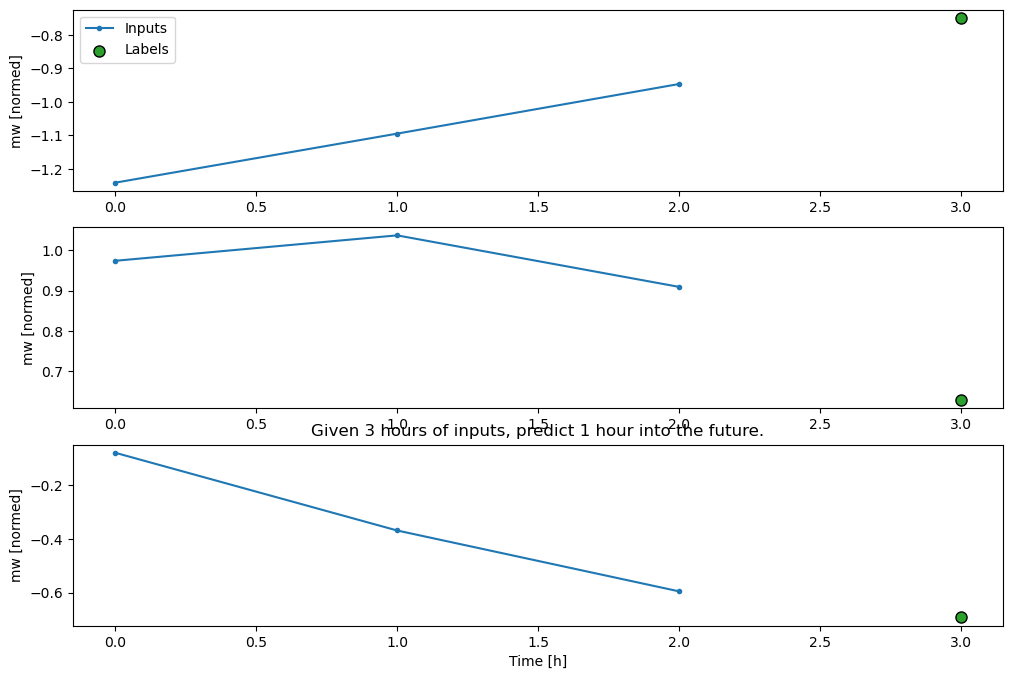

In [45]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [46]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

428/428 [==============================] - 0s 853us/step - loss: 0.0040 - mean_absolute_error: 0.0497


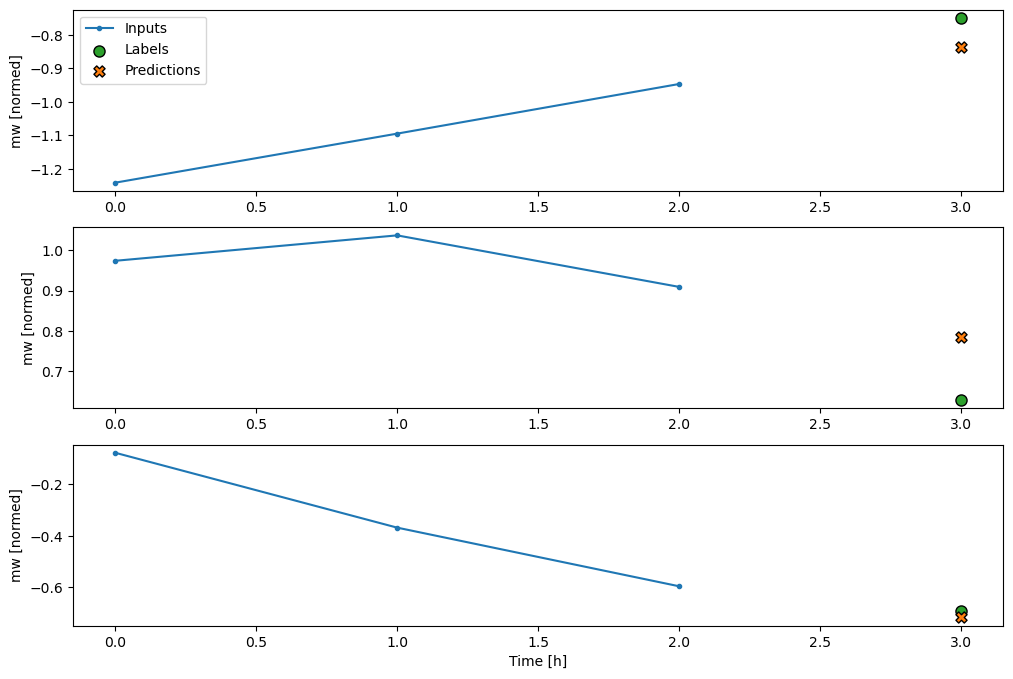

In [48]:
conv_window.plot(multi_step_dense)

### Convolution Neural Network

In [49]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 5)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

428/428 [==============================] - 0s 832us/step - loss: 0.0041 - mean_absolute_error: 0.0506


### Recurrent Neural Network

In [51]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences = True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [52]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

427/427 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0376


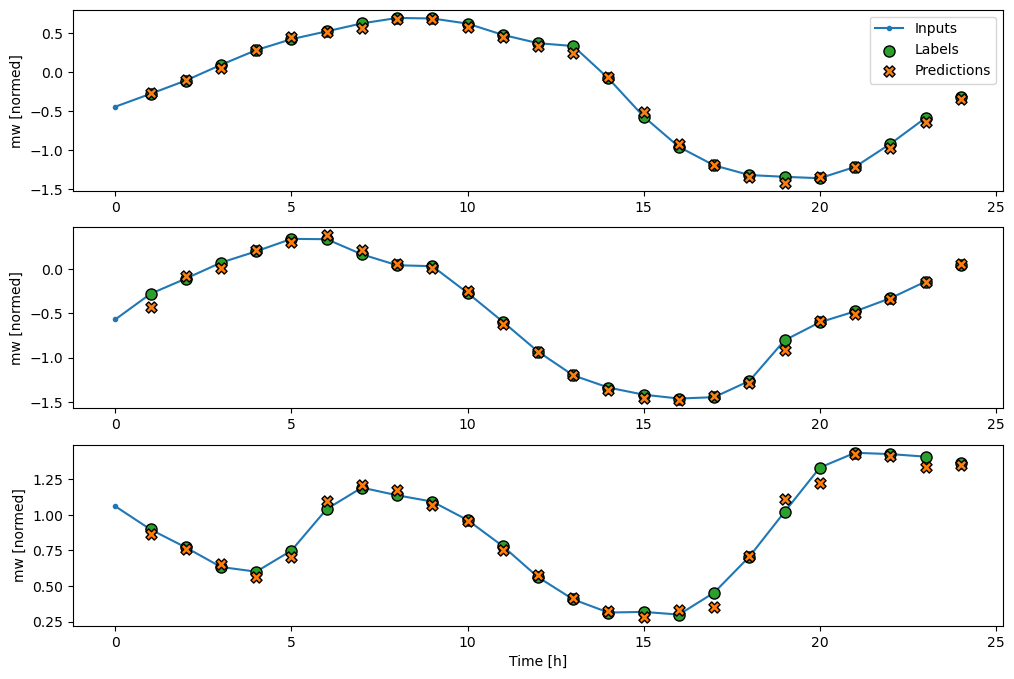

In [53]:
wide_window.plot(lstm_model)

### Overall Performance

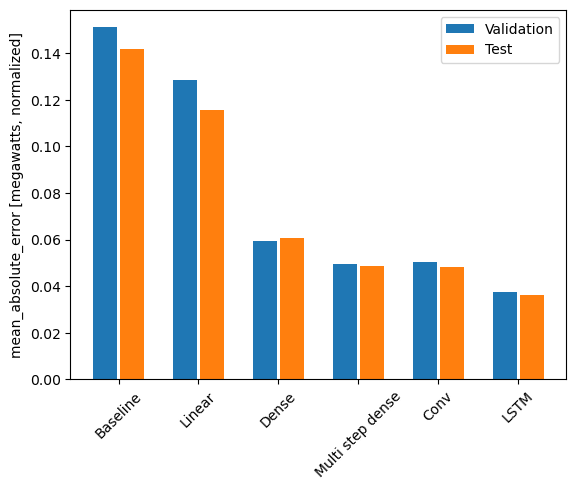

In [55]:
## Performance

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [megawatts, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [56]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1419
Linear      : 0.1158
Dense       : 0.0606
Multi step dense: 0.0488
Conv        : 0.0482
LSTM        : 0.0364
